Ch. 6 알고리즘 체인과 파이프라인 
===

- 파이프라인 : 데이터 변환 과정과 머신러닝 모델을 쉽게 연결해줌

In [13]:
%matplotlib inline
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import mglearn
import numpy as np
import pandas as pd

# 데이터 적재와 분할
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

# 훈련 데이터의 최솟값, 최댓값을 계산합니다
scaler = MinMaxScaler().fit(X_train)

In [4]:
# 훈련 데이터의 스케일을 조정합니다
X_train_scaled = scaler.transform(X_train)

svm = SVC()
# 스케일 조정된 훈련데이터에 SVM을 학습시킵니다
svm.fit(X_train_scaled, y_train)
# 테스트 데이터의 스케일을 조정하고 점수를 계산합니다
X_test_scaled = scaler.transform(X_test)
print("테스트 점수: {:.2f}".format(svm.score(X_test_scaled, y_test)))

테스트 점수: 0.95


## 6.1 데이터 전처리와 매개변수 선택

In [5]:
from sklearn.model_selection import GridSearchCV
# 이 코드는 예를 위한 것입니다. 실제로 사용하지 마세요.
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
              'gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 점수: {:.2f}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: ", grid.best_params_)

최상의 교차 검증 정확도: 0.98
테스트 점수: 0.97
최적의 매개변수:  {'C': 1, 'gamma': 1}


학습을 위해서 훈련 세트에 있는 모든 데이터를 사용하고, 스케일 조정된 훈련 데이터에서 그리드 서치를 사용. 

검증 폴드에 있는 정보까지 다 사용했기 때문에 최솟값과 최댓값이 훈련 데이터와 다를 수 있음.

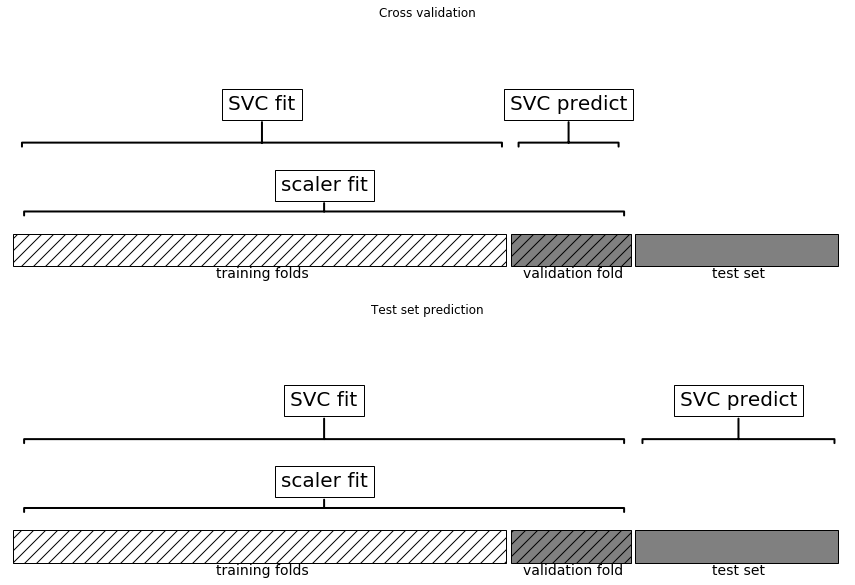

In [8]:
mglearn.plots.plot_improper_processing()

교차 검증 분할이 모든 전처리 과정보다 먼저 이루어져야 서로 포함되지 않는다. 

- 위 그래프 : fit. predict가 다 검증폴드 사용
- 아래 그래프 : 실제 성능 평가할때는 fit에서 테스트세트를 포함시키지 않음

## 6.2 파이프라인 구축하기

In [9]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

pipe.fit(X_train, y_train)
print("테스트 점수: {:.2f}".format(pipe.score(X_test, y_test)))

테스트 점수: 0.95


전처리 + 분류 과정을 위해 작성해야 할 코드가 줄어들고, cross_val_score나 GridSearchCV에 파이프라인을 하나의 추정기처럼 사용이 가능

## 6.3 그리드 서치에 파이프라인 적용하기

In [10]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100],
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))
print("최적의 매개변수: {}".format(grid.best_params_))

최상의 교차 검증 정확도: 0.98
테스트 세트 점수: 0.97
최적의 매개변수: {'svm__gamma': 1, 'svm__C': 1}


파이프라인용 매개변수 그리드는 단계 이름과 매개변수 이름을 밑줄 두개로 연결해 둡니다.

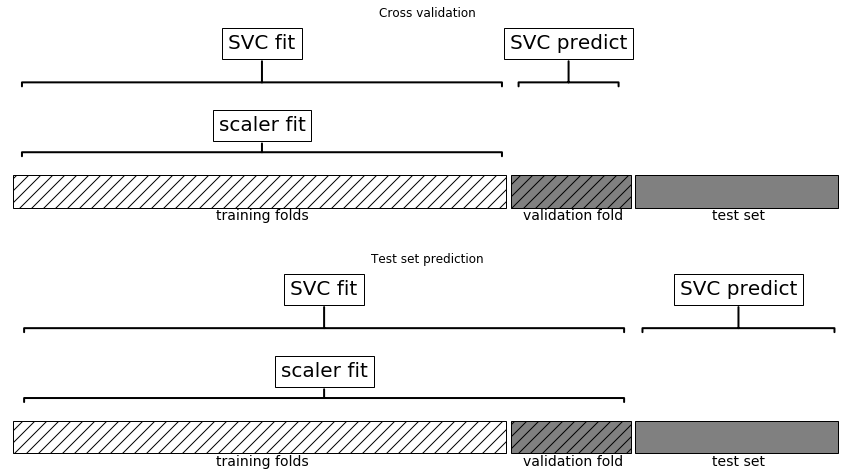

In [11]:
mglearn.plots.plot_proper_processing()

#### 정보 누설에 대한 예시
---

In [14]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression, percentile=5).fit(X, y)
X_selected = select.transform(X)
print("X_selected.shape: {}".format(X_selected.shape))

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge
print("교차 검증 점수 (릿지): {:.2f}".format(
      np.mean(cross_val_score(Ridge(), X_selected, y, cv=5))))

pipe = Pipeline([("select", SelectPercentile(score_func=f_regression,
                                             percentile=5)),
                 ("ridge", Ridge())])
print("교차 검증 점수 (파이프라인): {:.2f}".format(
      np.mean(cross_val_score(pipe, X, y, cv=5))))

X_selected.shape: (100, 500)
교차 검증 점수 (릿지): 0.91
교차 검증 점수 (파이프라인): -0.25


특성 선택 단계에서 일어나는 정보 누설을 막는 것이 모델의 성능을 평가하는데 큰 차이를 만든다.

(일반 릿지의 경우에는 훈련폴드, 테스트 폴드 다 포함해서 학습했을 가능성이 있음)

## 6.4 파이프라인 인터페이스

In [15]:
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        # 마지막 단계를 빼고 fit과 transform을 반복합니다
        X_transformed = estimator.fit_transform(X_transformed, y)
    # 마지막 단계 fit을 호출합니다
    self.steps[-1][1].fit(X_transformed, y)
    return self

각 단계에서 이전 단계의 transform의 출력을 입력으로 받아서 fit. transform메서드를 차례로 호출하게 되고, 마지막에는 fit만 호출

예측이라면 predict를 가져온다

In [16]:
def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        # 마지막 단계를 빼고 transform을 반복합니다
        X_transformed = step[1].transform(X_transformed)
    # 마지막 단계 predict을 호출합니다
    return self.steps[-1][1].predict(X_transformed)

### 6.4.1 make_pipleline을 사용한 파이프라인 생성

In [17]:
from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])

# 간소화된 방법 - 단계의 일므을 자동으로 만들어줌
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))
print("파이프라인 단계:\n{}".format(pipe_short.steps))

파이프라인 단계:
[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('svc', SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]


In [18]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print("파이프라인 단계:\n{}".format(pipe.steps))

파이프라인 단계:
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [22]:
pipelinePractice = pipe
print(pipelinePractice)

Pipeline(steps=[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))])


### 6.4.2 단계 속성에 접근하기

In [24]:
# cancer 데이터셋에 앞서 만든 파이프라인을 적용합니다
pipe.fit(cancer.data)
# "pca" 단계의 두 개 주성분을 추출합니다
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


### 6.4.3 그리드 서치 안의 파이프라인의 속성에 접근하기

In [26]:
from sklearn.linear_model import LogisticRegression

pipe = make_pipeline(StandardScaler(), LogisticRegression())

param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최상의 모델:\n{}".format(grid.best_estimator_))
print("로지스틱 회귀 단계:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"]))
print("로지스틱 회귀 계수:\n{}".format(
      grid.best_estimator_.named_steps["logisticregression"].coef_))

최상의 모델:
Pipeline(steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
로지스틱 회귀 단계:
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
로지스틱 회귀 계수:
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.39256847 -0.122934

### 6.5 전처리와 모델의 매개변수를 위한 그리드 서치

In [29]:
from sklearn.datasets import load_boston
boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target,
                                                    random_state=0)

from sklearn.preprocessing import PolynomialFeatures
pipe = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(),
    Ridge())



In [30]:
param_grid = {'polynomialfeatures__degree': [1, 2, 3],
              'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, y_train)

Process ForkPoolWorker-20:
Process ForkPoolWorker-21:
Process ForkPoolWorker-19:
Process ForkPoolWorker-22:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/Yeoni/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/Yeoni/anaconda/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()


KeyboardInterrupt: 

In [31]:
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3, -1),
                      xlabel="ridge__alpha", ylabel="polynomialfeatures__degree",
                      xticklabels=param_grid['ridge__alpha'],
                      yticklabels=param_grid['polynomialfeatures__degree'], vmin=0)

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [32]:
print("최적의 매개변수: {}".format(grid.best_params_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

param_grid = {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수: {:.2f}".format(grid.score(X_test, y_test)))

NotFittedError: This GridSearchCV instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.

[In] 30번이 컴퓨터 사양상 한계로 안 돌아갑니다.

다만 이제 우리가 얻을 수 있는 관점은 파이프라인에서도 스케일 조정-다항식 특성 선택-릿지 회귀로 진행해본 결과

다항식 특성도 선택할 수 있고(여기서는 2차원), 다항을 선택하지 않은 것 보다 더 좋은 결과를 얻을 수 있었습니다.

## 6.6 모델 선택을 위한 그리드 서치

In [33]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

from sklearn.ensemble import RandomForestClassifier

param_grid = [
    {'classifier': [SVC()], 'preprocessing': [StandardScaler()],
     'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
     'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
    {'classifier': [RandomForestClassifier(n_estimators=100)],
     'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 매개변수:\n{}\n".format(grid.best_params_))
print("최상의 교차 검증 점수: {:.2f}".format(grid.best_score_))
print("테스트 세트 점수: {:.2f}".format(grid.score(X_test, y_test)))

최적의 매개변수:
{'classifier__gamma': 0.01, 'classifier__C': 10, 'classifier': SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수: 0.99
테스트 세트 점수: 0.98


파이프라인을 사용하게 되면 처리 단계에서 발생할 수 있는 실수를 방지해주고 코드를 간결하게 작성할 수 있습니다. :)